# Rayhan Momin

### Note: Consulted 'Lectures in Quantitative Economics' (Sargent and Stachurski)
### Discussed with Yiran Fan, Fulin Li, Seongjin Park, Harshil Sahai, Christoph Schlom, Yang Su, Nishant Vats

In [2]:
# Import Useful Packages
import numpy as np
from scipy.optimize import fminbound
from scipy.stats import skew
import matplotlib.pyplot as plt
from numba import jit
import pickle
import quantecon as qe
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline

/Users/rayhanmomin/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Problem 1

In [26]:
# Load Data From Prevoius Session
pkl_file1 = open('val.pkl', 'rb')
v = pickle.load(pkl_file1)
pkl_file1.close()

pkl_file2 = open('op.pkl', 'rb')
op = pickle.load(pkl_file2)
pkl_file2.close()

In [27]:
# Primitives and Grids
A = 1
eta = -1.5 
psi = 0.1
beta = 0.95
K = 20
z_vec = np.linspace(0,7.5, 100)
z_indices = np.arange(100)
s = (K,K)
pi_mat1 = np.full(s, 0.04)
np.fill_diagonal(pi_mat1, 0.24)
omega = np.linspace(0.5,5,K)

In [28]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [29]:
# Compute consumer surplus
@jit
def consumer_surplus(q):
    return A**(-1/eta)*(1+1/eta)**(-1)*(q**(1+1/eta))

In [30]:
# Compute storage cost
@jit
def storage_cost(z_prime):
    return (psi/2)*(z_prime**2)

In [34]:
def _bellman_operator(v, Tv, pi_mat = pi_mat1, compute_policy = False):
    op = np.empty((len(z_vec),K))
    o_range = list(range(len(omega)))
    
    # Linear Interpolation of V along inventory grid
    v_func = lambda x, j: np.interp(x, z_vec, v[:,j])
    
    for z_idx, z in enumerate(z_vec):
        for o_idx, o in enumerate(omega):
            # Objective Function (as a Minimization Problem)
            def objective(z_prime):
                # Expectation of Next Period's Value
                y = sum(pi_mat[o_idx,j]*v_func(z_prime, j) for j in o_range)
                # Expression for Objective Function
                return - consumer_surplus(z + o - z_prime) + storage_cost(z_prime) - beta * y
            # Solution to Minimization Problem, Given Feasibility Constraint
            z_star = fminbound(objective, 10e-9, z + o)
            #print(z_idx, o_idx, find_nearest( z_vec,z_star))
            # Storing Value
            Tv[z_idx, o_idx] = - objective(z_star)
            # Storing Policy
            op[z_idx, o_idx] = find_nearest(z_vec, z_star) # Staying on grid specification
    if compute_policy:
        return Tv, op
    else:
        return Tv

In [35]:
def solve_optinven(initial_v, pi_mat = pi_mat1, tol=10e-9, max_iter=100):

    v = initial_v  # Set initial condition
    error = tol + 1
    i = 0

    Tv = np.empty((len(z_vec),K))

    # Iterate to find solution
    while error > tol and i < max_iter:
        v_new, op = _bellman_operator(v, Tv, compute_policy = True)
        error = np.max(np.abs(v_new - v))
        v[:] = v_new
        i += 1
        print(i, error)

    return v, op

## Problem 2

In [36]:
#initial_v = np.zeros((len(z_vec),K))
initial_v = v
v, op = solve_optinven(initial_v)

1 7.47562012293e-09


### Value Function

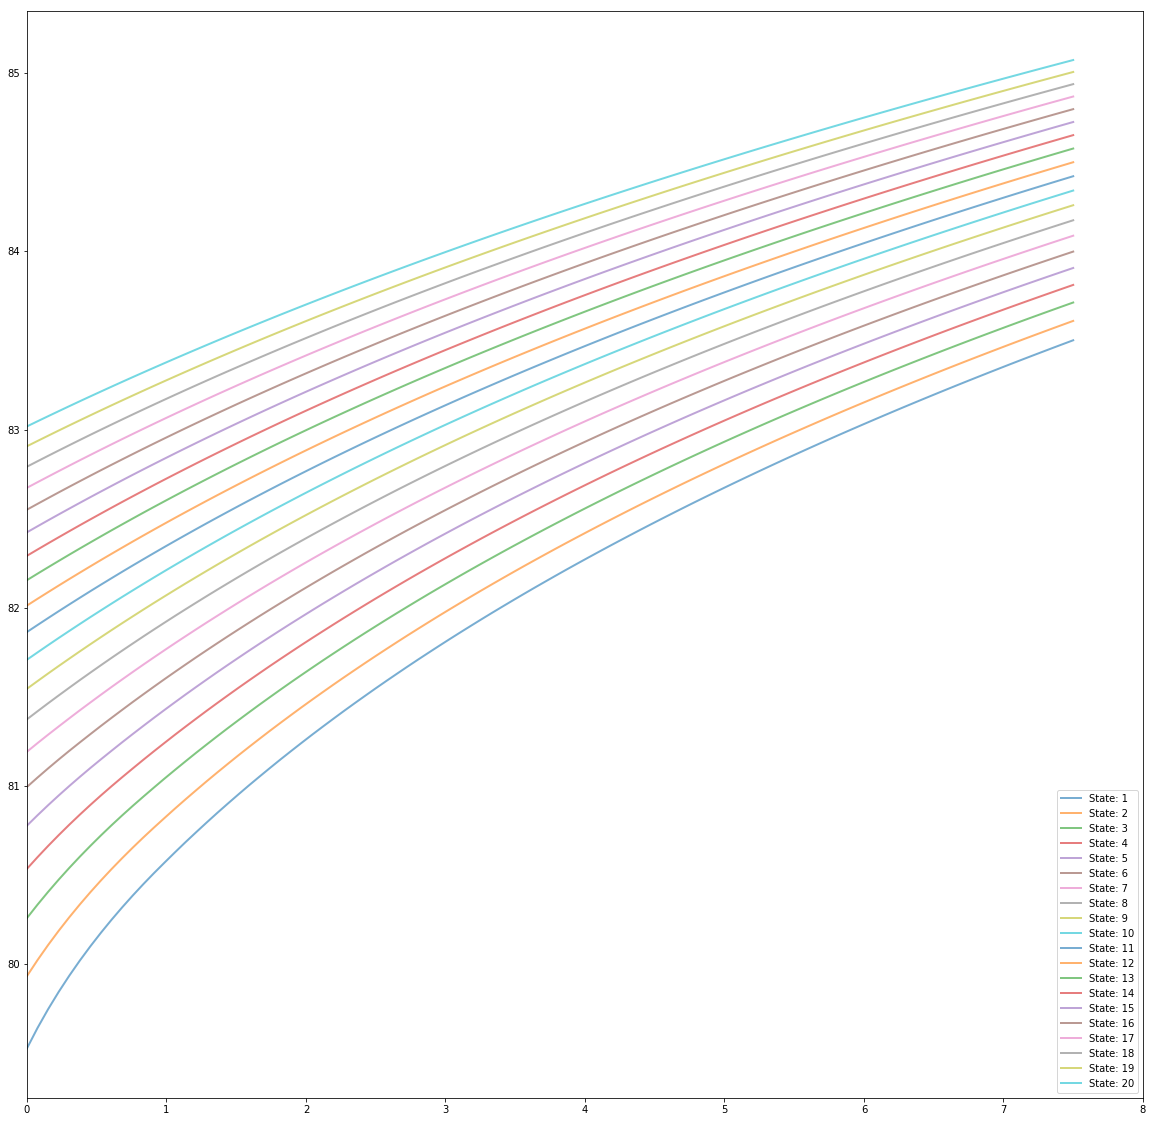

In [37]:
fig, ax = plt.subplots(figsize=(20, 20))
#ax.set_ylim(85, 92)
ax.set_xlim(0, 8)
for k in range(K):
    ax.plot(z_vec, v[:,k], lw=2, alpha=0.6, label= 'State: ' + str(k + 1))
ax.legend(loc='lower right')
plt.show()

### Optimal Policy Function

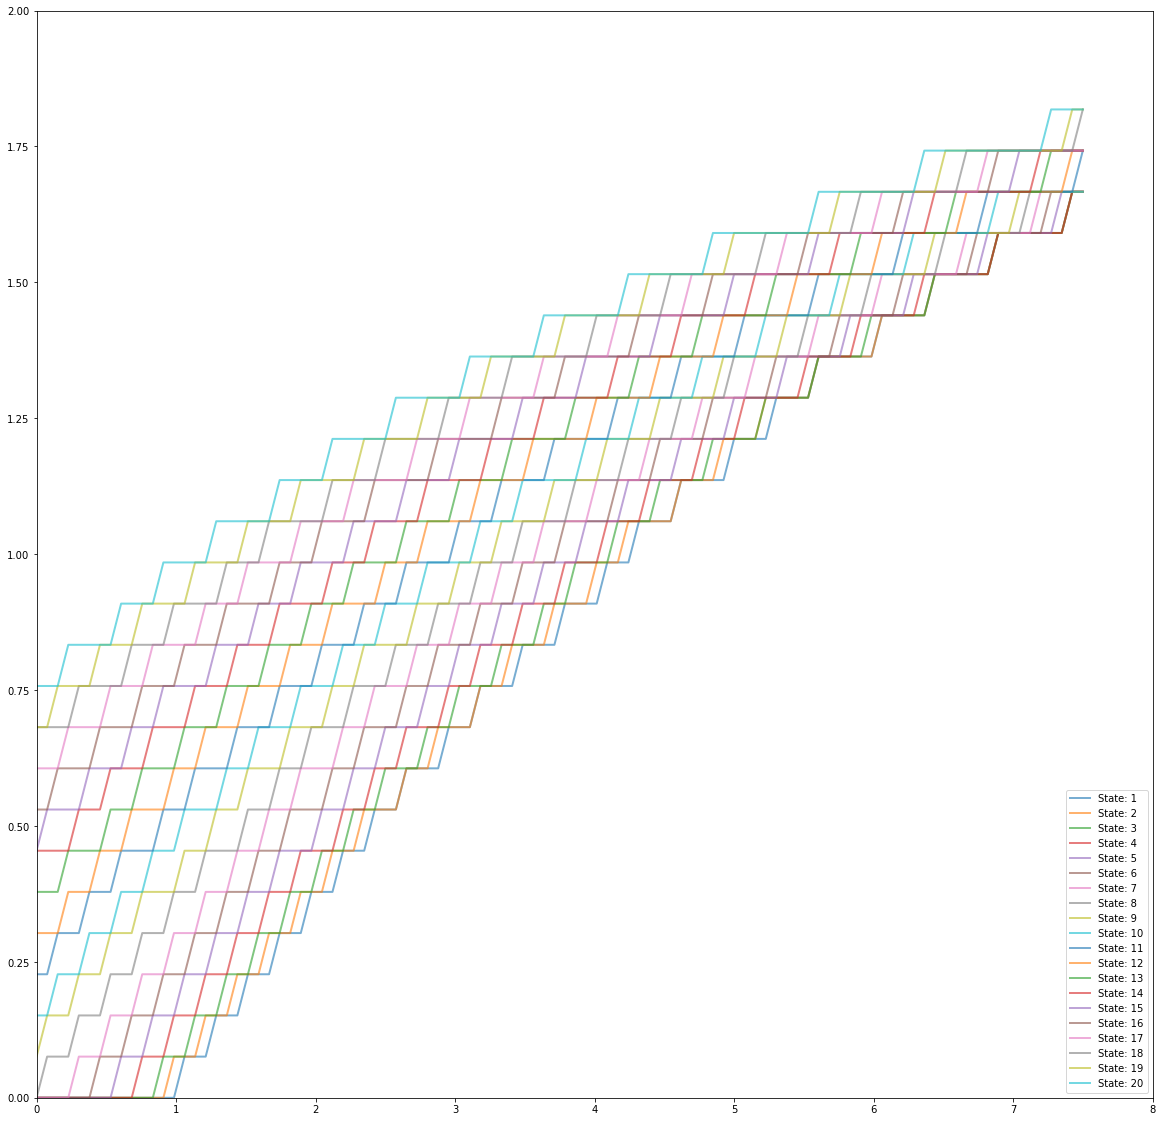

In [140]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(0, 2)
ax.set_xlim(0, 8)
for k in range(K):
    ax.plot(z_vec, op[:,k], lw=2, alpha=0.6, label= 'State: ' + str(k + 1))
ax.legend(loc='lower right')
plt.show()

### Price Functions

In [39]:
p_mat = np.empty_like(op)
for z_idx, z in enumerate(z_vec):
        for o_idx, o in enumerate(omega):
            z_prime = np.interp(z, z_vec, op[:,o_idx])
            p_mat[z_idx, o_idx] = z + o - z_prime
            p_mat[z_idx, o_idx] = (p_mat[z_idx, o_idx]/A)**(1/eta)

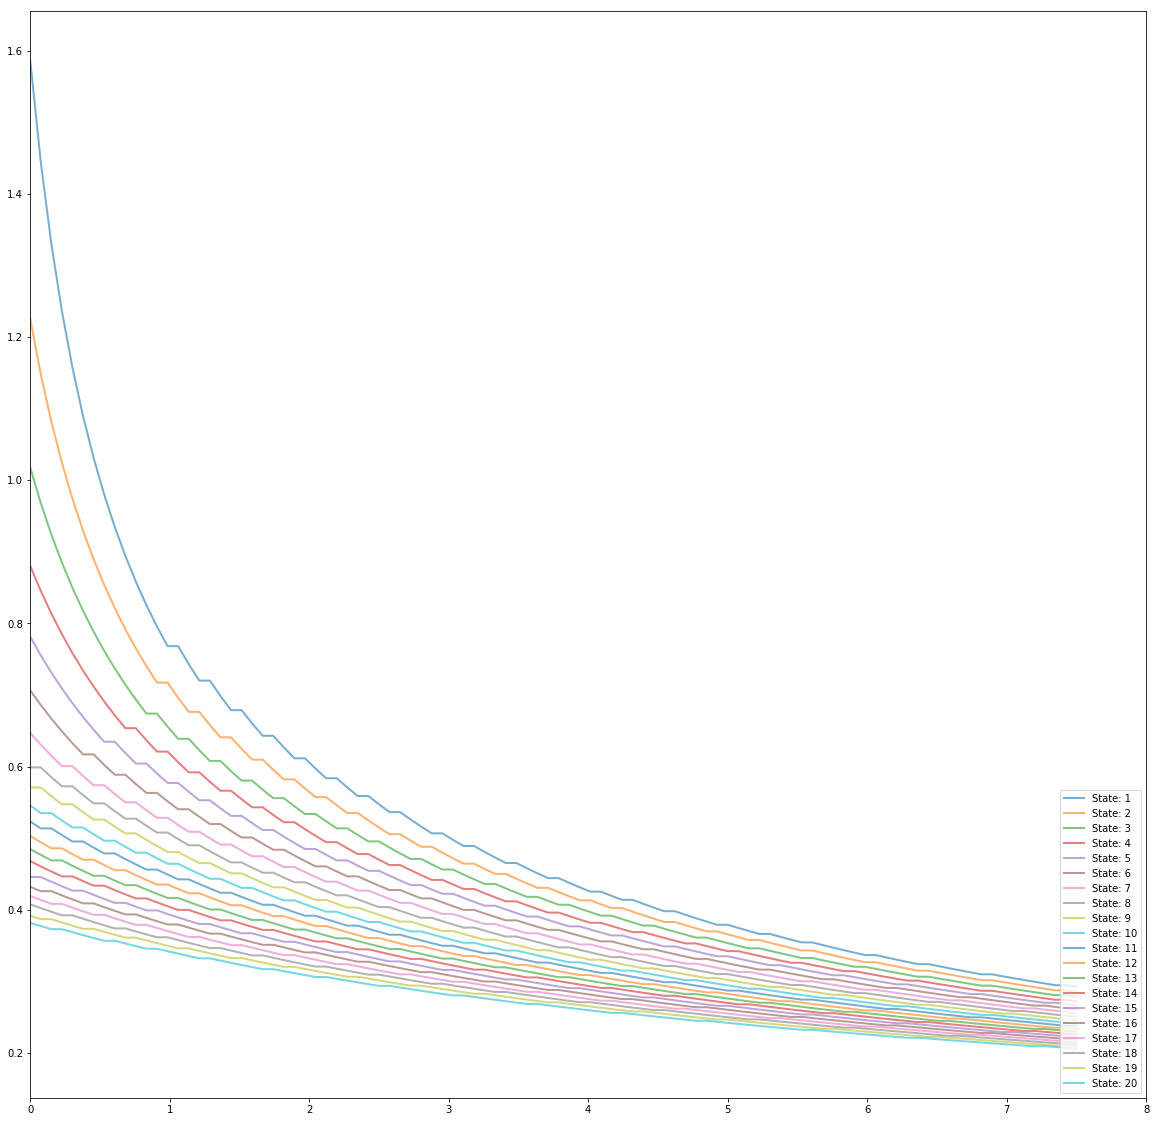

In [40]:
fig, ax = plt.subplots(figsize=(20, 20))
#ax.set_ylim(85, 92)
ax.set_xlim(0, 8)
for k in range(K):
    ax.plot(z_vec, p_mat[:,k], lw=2, alpha=0.6, label= 'State: ' + str(k + 1))
ax.legend(loc='lower right')
plt.show()

In [41]:
output1 = open('val.pkl', 'wb')
pickle.dump(v, output1)
output1.close()

output2 = open('op.pkl', 'wb')
pickle.dump(op, output2)
output2.close()

## Problem 3

In [180]:
int1 = np.empty((1000,20))
for k in range (K):
    int1[:,k] = np.interp(z_vec_ext, z_vec, op[:,k])

In [181]:
int2 = np.empty((1000,400))
for i in range(K):
    for j in range(K):
        int2[:, K*i+j] = np.interp(int1[:,i], z_vec, op[:,k])

### Residuals

### We solve the FOC and EC to obtain the EE (which give the residuals):

$$ Residual = - s^\prime (z_t + w_t - z_{t+1}) + \beta E [ s^\prime (z_t + w_{t+1} - z_{t+2} )\vert w_t ] $$

$$Residual = -\left( \frac{z_t + w_t - z_{t+1}}{A}\right)^{\frac{1}{\eta}} - \psi z_{t+1} + \beta \sum \limits_{w_{t+1}} p (w_{t+1} \vert w_t) \left( \frac{z_{t+1} + w_t - z_{t+2}}{A}\right)^{\frac{1}{\eta}} $$

In [182]:
# Compute Residuals
residuals = np.zeros((1000, K))
o_range = list(range(len(omega)))
for z_idx, z in enumerate(z_vec_ext):
    for o_idx, o in enumerate(omega):
        first_term = ((z + o - int1[z_idx,o_idx])/A)**(1/eta) + psi*int1[z_idx,o_idx]
        second_term = beta*(pi_mat1[o_idx,:]@(int1[z_idx,o_idx]*np.ones(K)+omega.transpose()-(int2[z_idx, K*(o_idx):K*(o_idx+1)]).transpose()))**(1/eta)
        residuals[z_idx, o_idx] = -first_term + second_term

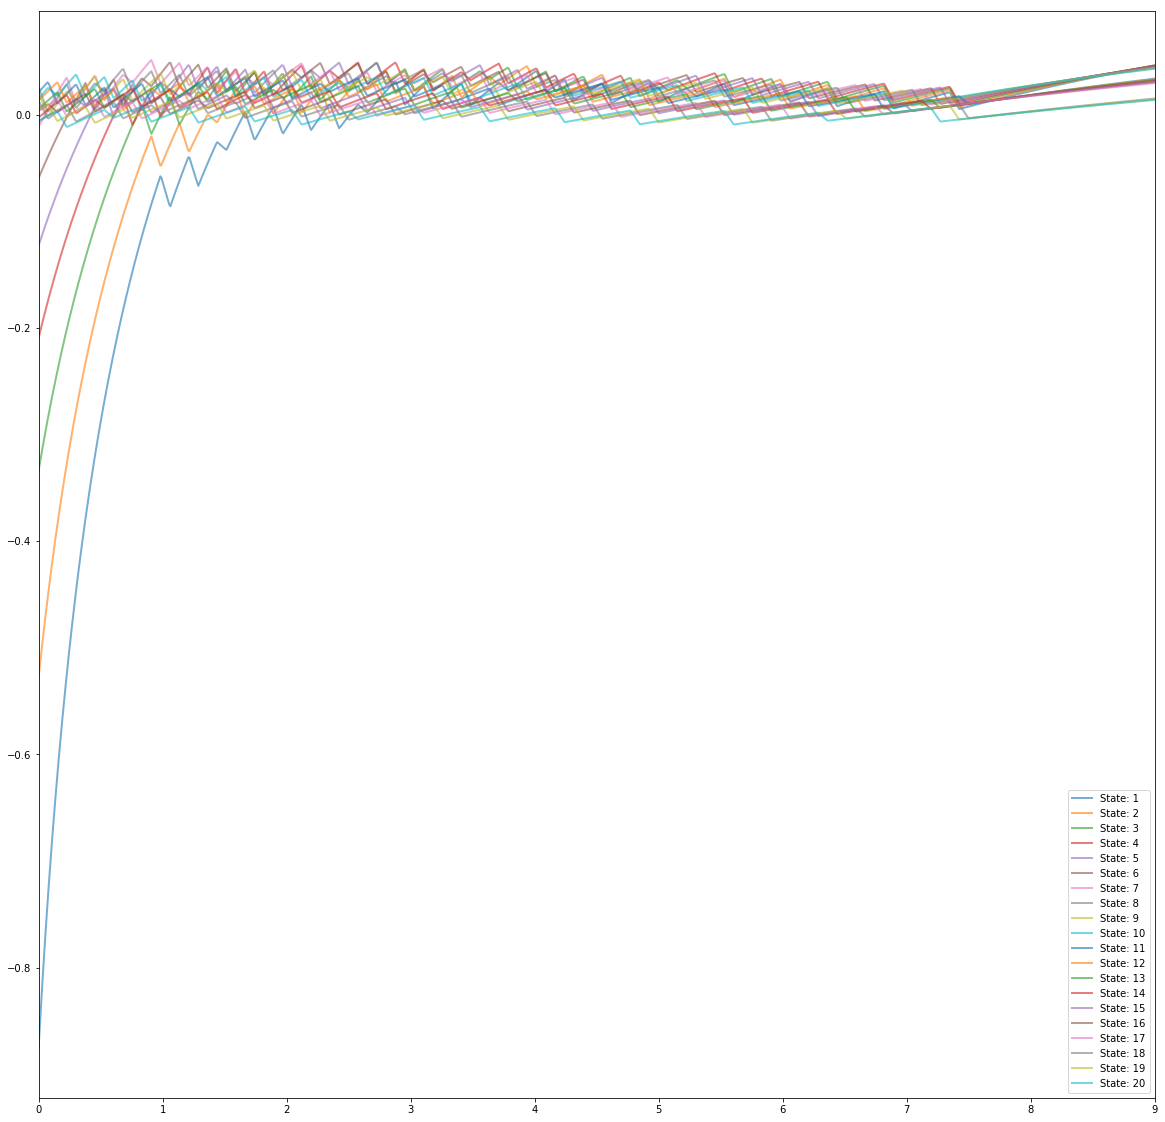

In [183]:
# Plot Residuals
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_xlim(0, 9)
for k in range(K):
    ax.plot(z_vec_ext, residuals[:,k], lw=2, alpha=0.6, label= 'State: ' + str(k + 1))
ax.legend(loc='lower right')
plt.show()

### Residuals appear to be decreasing as the state index increases. We see erratic behavior at the end, perhaps due to extrapolation. However, the residuals seem small in magnitude and clustered around 0. This indicates that the estimated policy function is a good approximation. 

## Problem 4

In [188]:
# Draw sequence of 100,000 realizations of omega
P = pi_mat1
mc = qe.MarkovChain(P)
O = mc.simulate(ts_length=100000)
np.mean(O == 0)
O_draws = omega[O]

In [189]:
# Initialize Vectors
z_sim = np.empty(len(O)+1)
z_sim[0] = 3.5
q_sim = np.empty(len(O))
p_sim = np.empty(len(O))

In [190]:
# Manual Sim for First Period
z_sim[1] = np.interp(z_sim[0], z_vec_ext, op_ext[:,O[0]])
q_sim[0] = z_sim[0] + O_draws[0] - z_sim[1]
p_sim[0] = (q_sim[0]/A)**(1/eta)

In [191]:
# Simulation
for sim in range(len(O)):
    z_sim[sim+1] = np.interp(z_sim[sim], z_vec_ext, op_ext[:,O[sim]])
    q_sim[sim] = z_sim[sim] + O_draws[sim] - z_sim[sim+1]
    p_sim[sim] = (q_sim[sim]/A)**(1/eta)

### Harvest Size

Mean:  2.75083971292
Median:  2.63157894737
Standard Deviation:  1.36658965598
Skew:  -0.0006235150432426087
Autocorrelation: 


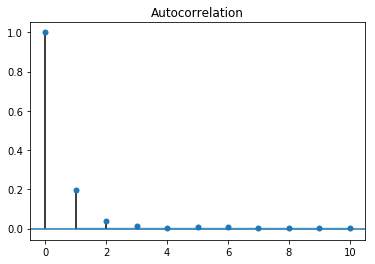

In [192]:
print('Mean: ', np.mean(O_draws[1000:]))
print('Median: ', np.median(O_draws[1000:]))
print('Standard Deviation: ', np.std(O_draws[1000:]))
print('Skew: ', skew(O_draws[1000:]))
print('Autocorrelation: ')
plot_acf(O_draws[1000:], lags = 10)
plt.show()

### Consumption Size

Mean:  2.75084888813
Median:  2.79209210689
Standard Deviation:  1.15881858747
Skew:  -0.1006146014486529
Autocorrelation: 


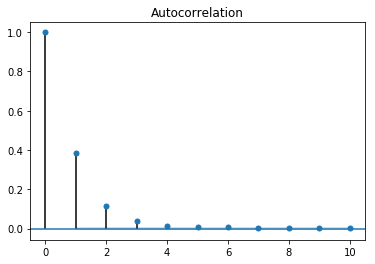

In [193]:
print('Mean: ', np.mean(q_sim[1000:]))
print('Median: ', np.median(q_sim[1000:]))
print('Standard Deviation: ', np.std(q_sim[1000:]))
print('Skew: ', skew(q_sim[1000:]))
print('Autocorrelation: ')
plot_acf(q_sim[1000:], lags = 10)
plt.show()

### Inventory Size

Mean:  0.338459539997
Median:  0.30303030303
Standard Deviation:  0.30650792353
Skew:  0.3185343947304289
Autocorrelation: 


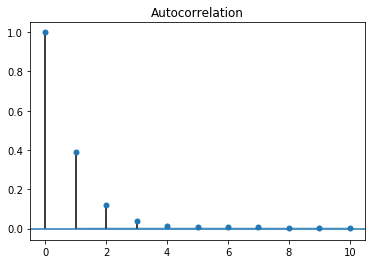

In [194]:
print('Mean: ', np.mean(z_sim[1000:]))
print('Median: ', np.median(z_sim[1000:]))
print('Standard Deviation: ', np.std(z_sim[1000:]))
print('Skew: ', skew(z_sim[1000:]))
print('Autocorrelation: ')
plot_acf(z_sim[1000:], lags = 10)
plt.show()

### Prices

Mean:  0.591640386255
Median:  0.504328494159
Standard Deviation:  0.256541293572
Skew:  1.9552856039903699
Autocorrelation: 


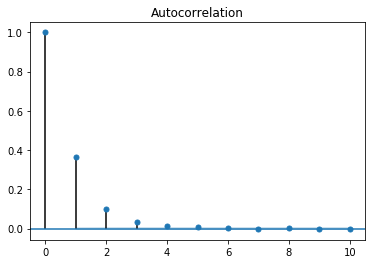

In [195]:
print('Mean: ', np.mean(p_sim[1000:]))
print('Median: ', np.median(p_sim[1000:]))
print('Standard Deviation: ', np.std(p_sim[1000:]))
print('Skew: ', skew(p_sim[1000:]))
print('Autocorrelation: ')
plot_acf(p_sim[1000:], lags = 10)
plt.show()

## Analysis of Price Distribution

(array([ 36322.,  28488.,  12331.,   8822.,   4726.,   3456.,    798.,
          2574.,    248.,   2235.]),
 array([ 0.32275275,  0.44921758,  0.57568241,  0.70214724,  0.82861207,
         0.9550769 ,  1.08154173,  1.20800656,  1.33447139,  1.46093622,
         1.58740105]),
 <a list of 10 Patch objects>)

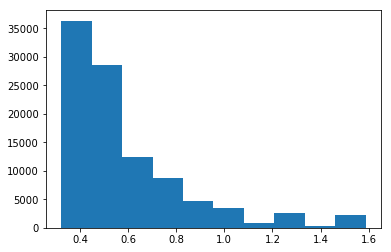

In [196]:
plt.hist(p_sim)

In [94]:
# Invariant Distribution of Harvests
mc.stationary_distributions

array([[ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,
         0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,
         0.05,  0.05]])

###  The historgram of prices does not resemble the invariant distribution of the harvests. This may be because of the convex costs associated with storing harvests. We see a positive skew in prices versus the flat, even distribution for harvests. The autocorrelation of prices, inventory, and consumption are very similar and may be affected by a similar reason. The autocorrelation is also higher than that of harvests. This relative comparison suggests shocks are more persistent in the price, inventory, and consumption variables than the actual harvests itself. The reason for this may be smoothing behavior by the consumer.

# Repeat with iid shocks

In [98]:
pi_mat2 = np.full(s, 0.05)

In [174]:
# Load Data From Prevoius Session
pkl_file3 = open('val2.pkl', 'rb')
v2 = pickle.load(pkl_file3)
pkl_file3.close()

pkl_file4 = open('op2.pkl', 'rb')
op2 = pickle.load(pkl_file4)
pkl_file4.close()

In [100]:
#initial_v2 = np.zeros((len(z_vec),K))
initial_v2 = v2
v2, op2 = solve_optinven(initial_v2, pi_mat2)

1 8.84280382252e-09


### Value Function

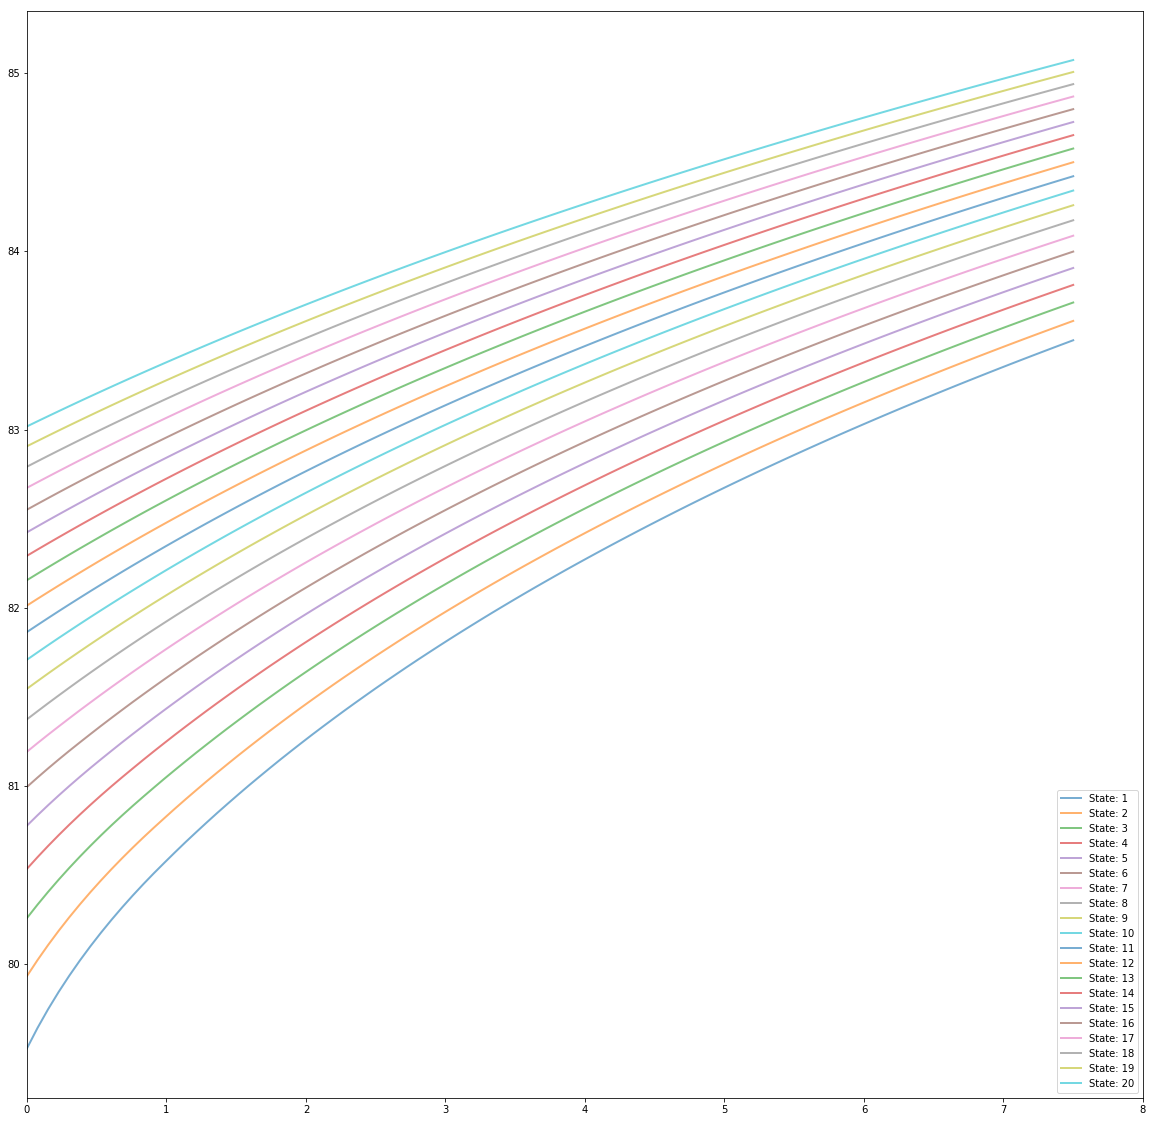

In [103]:
fig, ax = plt.subplots(figsize=(20, 20))
#ax.set_ylim(85, 92)
ax.set_xlim(0, 8)
for k in range(K):
    ax.plot(z_vec, v2[:,k], lw=2, alpha=0.6, label= 'State: ' + str(k + 1))
ax.legend(loc='lower right')
plt.show()

### Optimal Policy Function

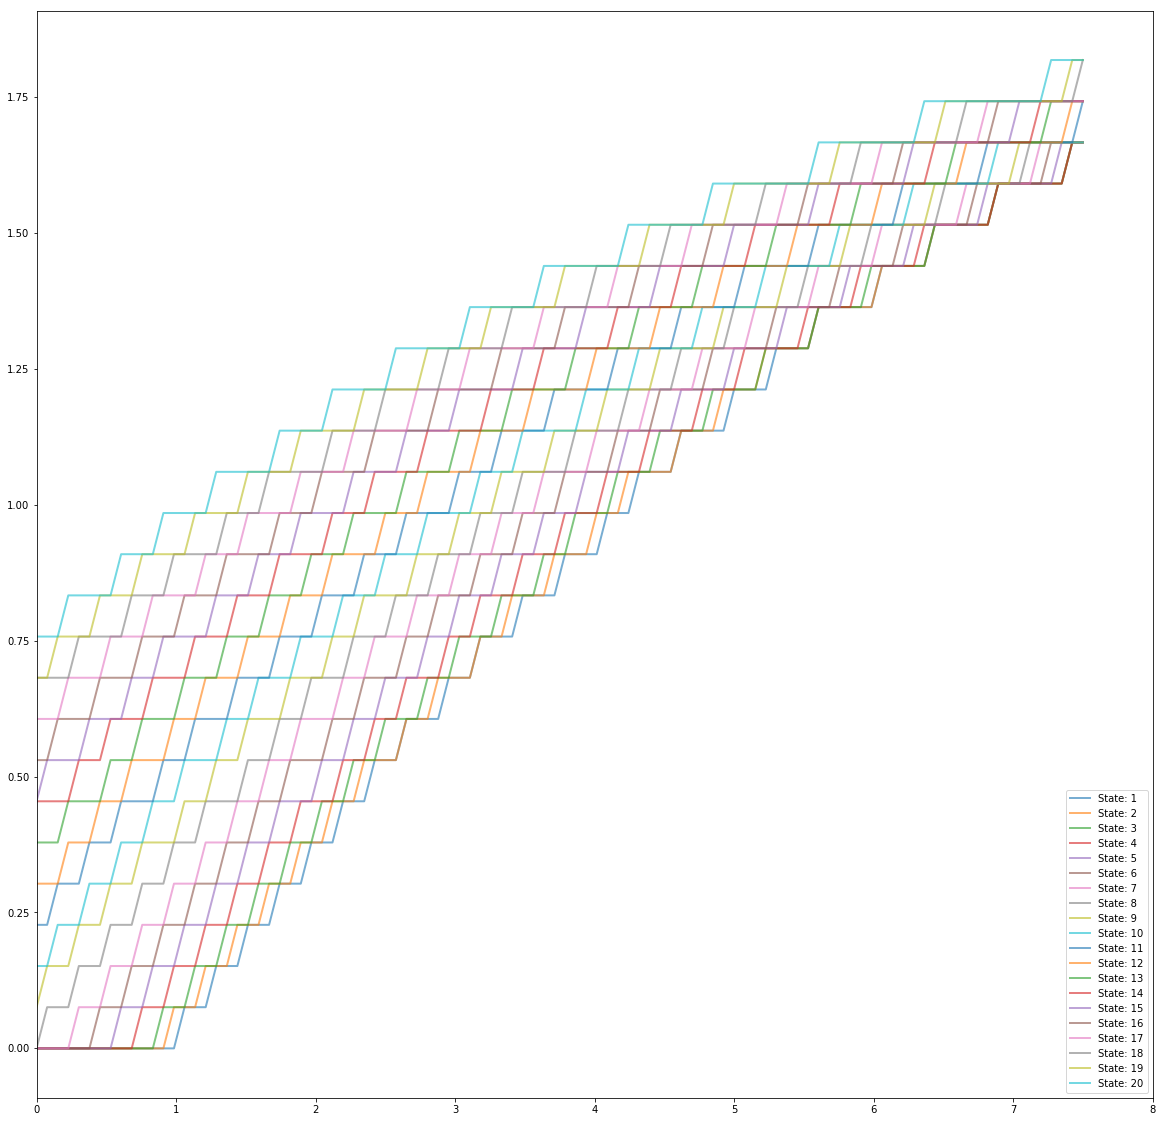

In [102]:
fig, ax = plt.subplots(figsize=(20, 20))
#ax.set_ylim(85, 92)
ax.set_xlim(0, 8)
for k in range(K):
    ax.plot(z_vec, op2[:,k], lw=2, alpha=0.6, label= 'State: ' + str(k + 1))
ax.legend(loc='lower right')
plt.show()

### Prices

In [113]:
p_mat2 = np.empty_like(op2)
for z_idx, z in enumerate(z_vec):
        for o_idx, o in enumerate(omega):
            z_prime = np.interp(z, z_vec, op2[:,o_idx])
            p_mat2[z_idx, o_idx] = z + o - z_prime
            p_mat2[z_idx, o_idx] = (p_mat2[z_idx, o_idx]/A)**(1/eta)

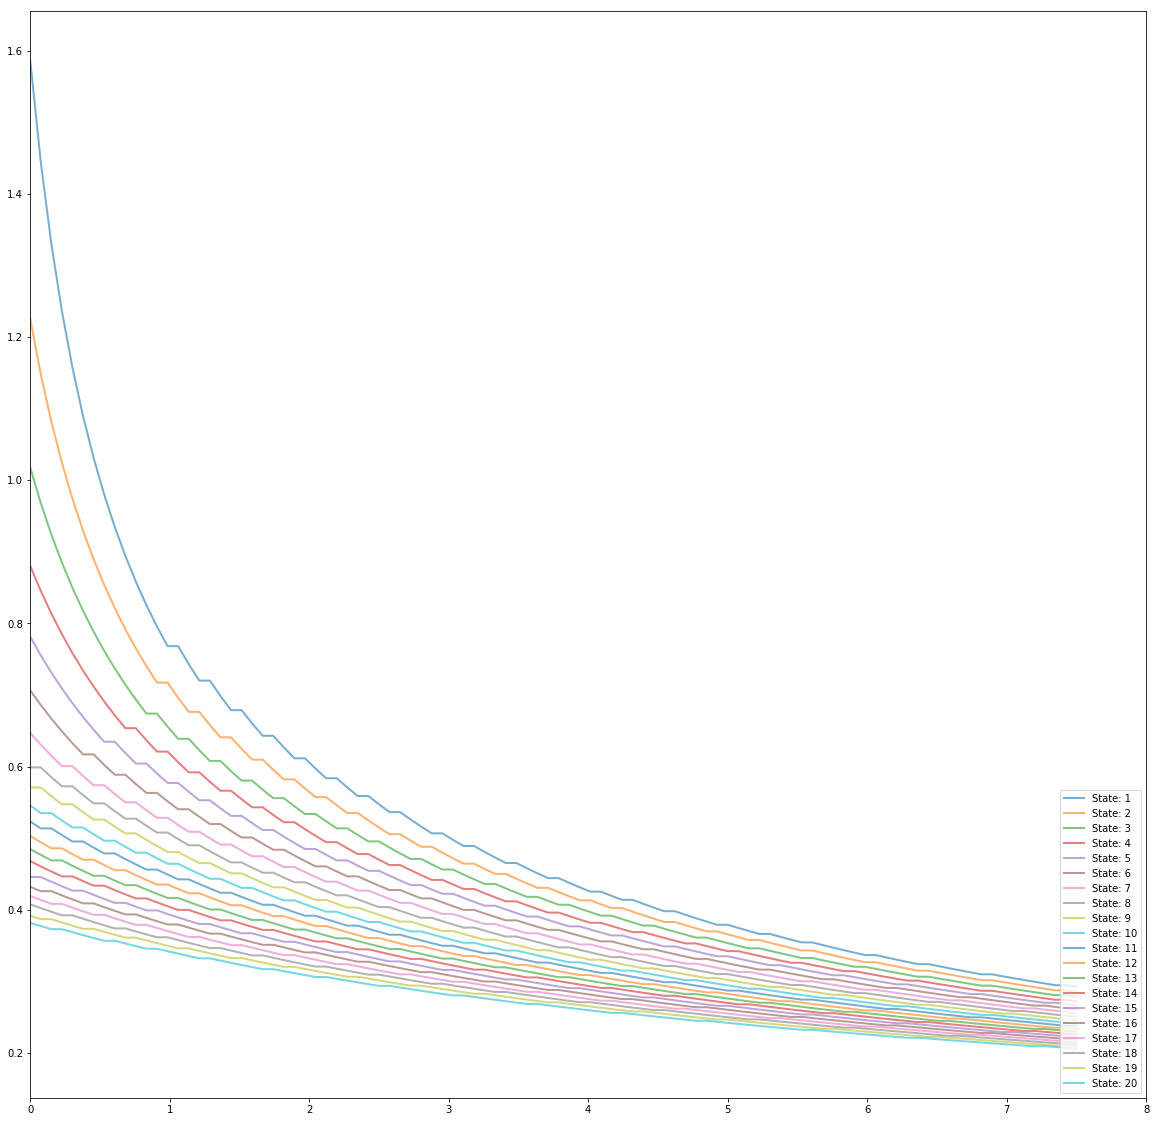

In [114]:
fig, ax = plt.subplots(figsize=(20, 20))
#ax.set_ylim(85, 92)
ax.set_xlim(0, 8)
for k in range(K):
    ax.plot(z_vec, p_mat2[:,k], lw=2, alpha=0.6, label= 'State: ' + str(k + 1))
ax.legend(loc='lower right')
plt.show()

In [50]:
output3 = open('val2.pkl', 'wb')
pickle.dump(v2, output3)
output3.close()

output4 = open('op2.pkl', 'wb')
pickle.dump(op2, output4)
output4.close()

### Residual Plot

In [184]:
int1 = np.empty((1000,20))
for k in range (K):
    int1[:,k] = np.interp(z_vec_ext, z_vec, op2[:,k])

In [185]:
int2 = np.empty((1000,400))
for i in range(K):
    for j in range(K):
        int2[:, K*i+j] = np.interp(int1[:,i], z_vec, op2[:,k])

In [186]:
# Compute Residuals
residuals = np.zeros((1000, K))
o_range = list(range(len(omega)))
for z_idx, z in enumerate(z_vec_ext):
    for o_idx, o in enumerate(omega):
        first_term = ((z + o - int1[z_idx,o_idx])/A)**(1/eta) + psi*int1[z_idx,o_idx]
        second_term = beta*(pi_mat1[o_idx,:]@(int1[z_idx,o_idx]*np.ones(K)+omega.transpose()-(int2[z_idx, K*(o_idx):K*(o_idx+1)]).transpose()))**(1/eta)
        residuals[z_idx, o_idx] = -first_term + second_term

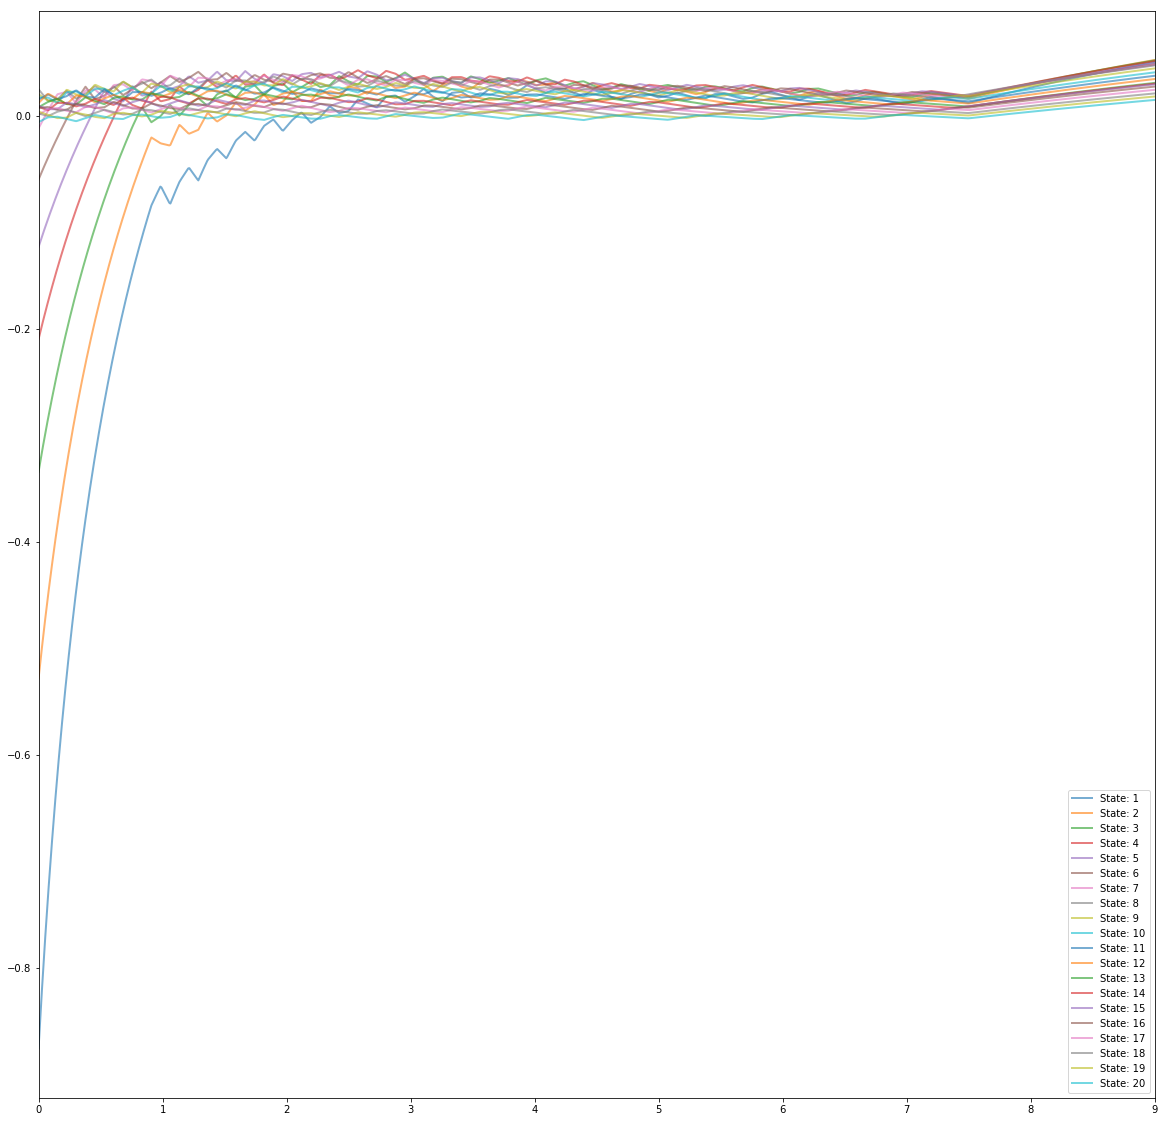

In [187]:
# Plot Residuals
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_xlim(0, 9)
for k in range(K):
    ax.plot(z_vec_ext, residuals[:,k], lw=2, alpha=0.6, label= 'State: ' + str(k + 1))
ax.legend(loc='lower right')
plt.show()

### Residuals appear to be decreasing as the state index increases. We see erratic behavior at the end, perhaps due to extrapolation. However, the residuals seem small in magnitude and clustered around 0. This indicates that the estimated policy function is a good approximation. 

### Simulation

In [120]:
# Draw sequence of 100,000 realizations of omega
P = pi_mat2
mc = qe.MarkovChain(P)
O = mc.simulate(ts_length=100000)
np.mean(O == 0)
O_draws = omega[O]

In [121]:
# Initialize Vectors
z_sim = np.empty(len(O)+1)
z_sim[0] = 3.5
q_sim = np.empty(len(O))
p_sim = np.empty(len(O))

In [122]:
# Manual Sim for First Period
z_sim[1] = np.interp(z_sim[0], z_vec_ext, op_ext[:,O[0]])
q_sim[0] = z_sim[0] + O_draws[0] - z_sim[1]
p_sim[0] = (q_sim[0]/A)**(1/eta)

In [123]:
# Simulation
for sim in range(len(O)):
    z_sim[sim+1] = np.interp(z_sim[sim], z_vec_ext, op_ext[:,O[sim]])
    q_sim[sim] = z_sim[sim] + O_draws[sim] - z_sim[sim+1]
    p_sim[sim] = (q_sim[sim]/A)**(1/eta)

### Harvest

Mean:  2.74947368421
Median:  2.63157894737
Standard Deviation:  1.36169314998
Skew:  0.008100839136009296
Autocorrelation: 


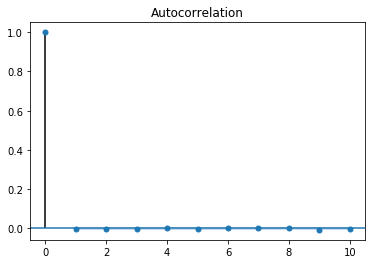

In [124]:
print('Mean: ', np.mean(O_draws[1000:]))
print('Median: ', np.median(O_draws[1000:]))
print('Standard Deviation: ', np.std(O_draws[1000:]))
print('Skew: ', skew(O_draws[1000:]))
print('Autocorrelation: ')
plot_acf(O_draws[1000:], lags = 10)
plt.show()

### Consumption

Mean:  2.74947447926
Median:  2.78309409888
Standard Deviation:  1.10568332342
Skew:  -0.11511943835165404
Autocorrelation: 


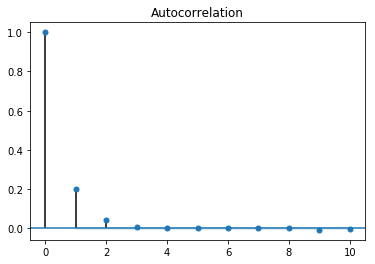

In [125]:
print('Mean: ', np.mean(q_sim[1000:]))
print('Median: ', np.median(q_sim[1000:]))
print('Standard Deviation: ', np.std(q_sim[1000:]))
print('Skew: ', skew(q_sim[1000:]))
print('Autocorrelation: ')
plot_acf(q_sim[1000:], lags = 10)
plt.show()

### Inventory

Mean:  0.332818014078
Median:  0.30303030303
Standard Deviation:  0.29628775885
Skew:  0.29579208006320445
Autocorrelation: 


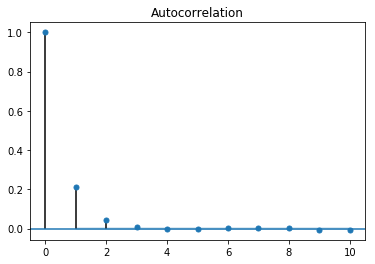

In [126]:
print('Mean: ', np.mean(z_sim[1000:]))
print('Median: ', np.median(z_sim[1000:]))
print('Standard Deviation: ', np.std(z_sim[1000:]))
print('Skew: ', skew(z_sim[1000:]))
print('Autocorrelation: ')
plot_acf(z_sim[1000:], lags = 10)
plt.show()

### Prices

Mean:  0.581918076992
Median:  0.505414937162
Standard Deviation:  0.235428517241
Skew:  1.988797207355386
Autocorrelation: 


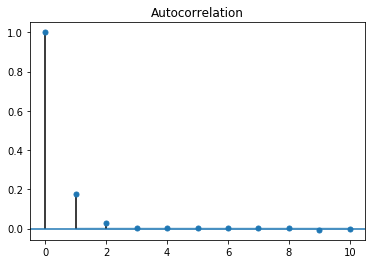

In [127]:
print('Mean: ', np.mean(p_sim[1000:]))
print('Median: ', np.median(p_sim[1000:]))
print('Standard Deviation: ', np.std(p_sim[1000:]))
print('Skew: ', skew(p_sim[1000:]))
print('Autocorrelation: ')
plot_acf(p_sim[1000:], lags = 10)
plt.show()

(array([ 38315.,  28848.,  14100.,   6185.,   4663.,   3313.,    790.,
          2048.,    314.,   1424.]),
 array([ 0.34202914,  0.46656634,  0.59110353,  0.71564072,  0.84017791,
         0.9647151 ,  1.08925229,  1.21378948,  1.33832667,  1.46286386,
         1.58740105]),
 <a list of 10 Patch objects>)

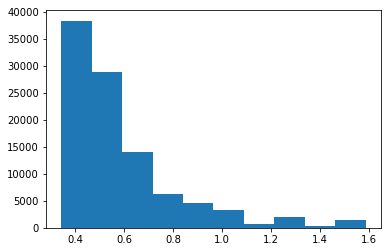

In [128]:
plt.hist(p_sim)

In [57]:
# Invariant Distribution of Harvests
mc.stationary_distributions

array([[ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,
         0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,
         0.05,  0.05]])

### As seen, all the results from before hold. The autocorrelation of harvest shocks has predictably fallen to 0 but there is still persistent/smoothing in the other variables, though to a lesser extent then before since there is greater mean reversion.

# Rewriting Bellman Equation

### Since the shocks are IID, we no longer require a state variable for the realization of the shock. Thus, we assume that each period follows the stationary distribution for the realization of the harvest. Hence, we can rewrite the Bellman equation as:

$$ \text{Let } x = z + w.$$

$$ \tilde{v}(x) = \max \limits_{x \prime \in [0,x]} S(x - x \prime) - C(x \prime) + \beta \sum \limits_{j=1}^{K} p(w_j) \tilde{v}(x\prime + w_j)$$